In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(15,5)})

In [18]:
def calculate_corr_ci(df1, df2, alpha=0.05):
    correlations = []
    ci_lower = []
    ci_upper = []

    for column in df1.columns:
        r, _ = stats.pearsonr(df1[column], df2[column])
        r_z = np.arctanh(r)
        se = 1/np.sqrt(df1[column].size-3)
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))

        correlations.append(r)
        ci_lower.append(lo)
        ci_upper.append(hi)

    return correlations, ci_lower, ci_upper

###  Preprocess

Read result files

In [19]:
users = pd.read_csv('results/Calibrated Predictions Survey - users.csv', index_col='id')
preds = pd.read_csv('results/Calibrated Predictions Survey - predictions.csv', index_col='id')
labels = pd.read_csv('results/Calibrated Predictions Survey - labels.csv', index_col='id')
pred_test = pd.read_csv('results/Calibrated Predictions Survey - pred_test.csv', index_col='id')
label_test = pd.read_csv('results/Calibrated Predictions Survey - outcome_test.csv', index_col='id')
first_rate = pd.read_csv('results/Calibrated Predictions Survey - first_rate.csv', index_col='id')
last_rate = pd.read_csv('results/Calibrated Predictions Survey - last_rate.csv', index_col='id')

Replace values in data

In [20]:
preds_outcome = preds.applymap(lambda x: 1 if x > 50 else 0)

map = {"Yes": 1, "No": 0}
label_test = label_test.applymap(lambda x: map.get(x, -1))

Get every model indexes

In [21]:
# get all unique models names in users that dont start with 'nn'
models_names = [model for model in users['model_name'].unique() if not model.startswith('NN')]
model_indexes = {}

# get indexes of every model name
for model in models_names:
    model_indexes[model] = users.index[users['model_name'] == model].tolist()

### Average user trust in the system

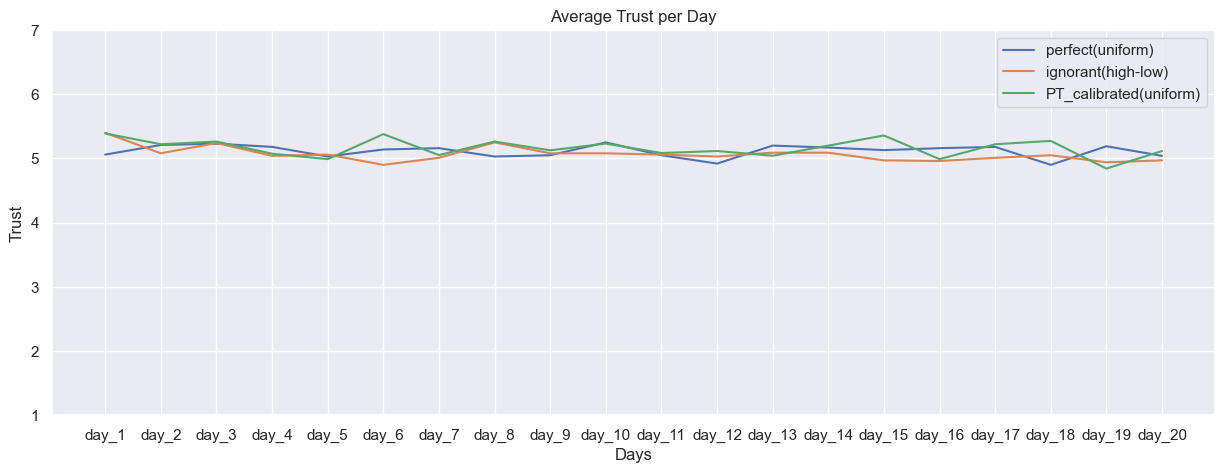

In [22]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns, y=last_rate_model_mean, 
                     dashes=False, markers=True, label=model)

p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

### User actions according to system predictions

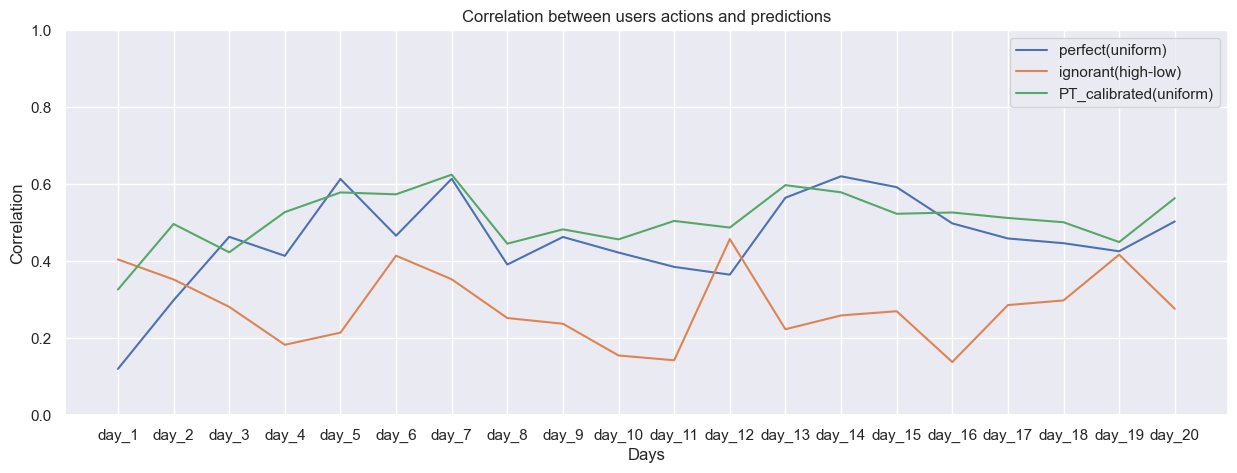

In [23]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    first_rate_model = first_rate.loc[model_indexes[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index, y=cors, dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

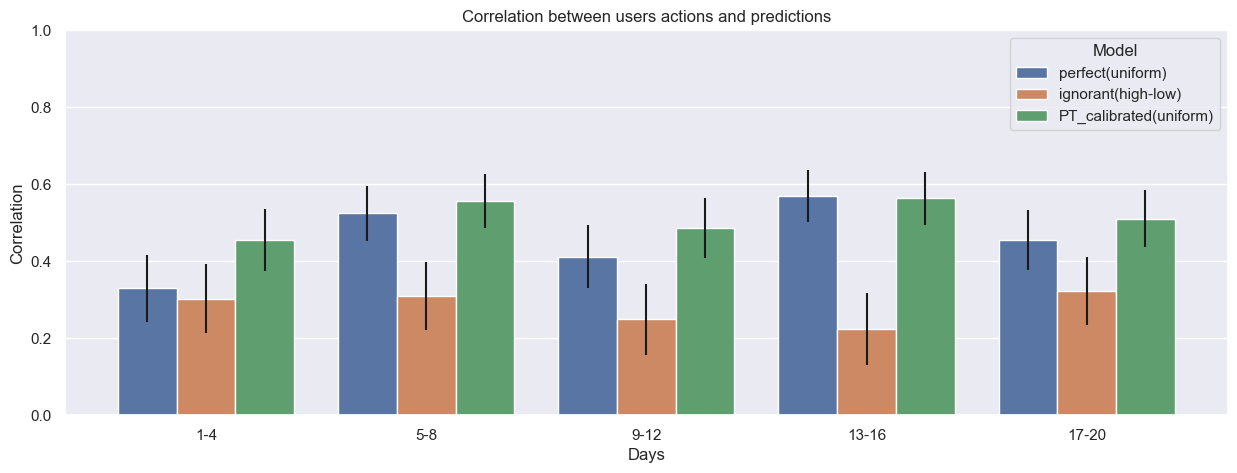

In [24]:
# calculate and plot correlation between model prediction and first_rate for each model
df_corr_ci = pd.DataFrame({'Model': [], 'Correlation': [], 'CI Lower': [], 'CI Upper': [], 'Day': []})

num_days_in_group = 4
grouped_days = [preds.columns[i:i+num_days_in_group] for i in range(0, len(preds.columns), num_days_in_group)]
grouped_days_names = ['1-4', '5-8', '9-12', '13-16', '17-20']

for i, model in enumerate(models_names):
    preds_model = preds.loc[model_indexes[model]]
    grouped_preds_model = pd.DataFrame()
    for group in grouped_days:
        grouped_preds_model = pd.concat([grouped_preds_model, preds_model[group].apply(list, axis=1)], axis=1)
    grouped_preds_model.columns = grouped_days_names
    grouped_preds_model = grouped_preds_model.explode(grouped_days_names)
    
    first_rate_model = first_rate.loc[model_indexes[model]]
    grouped_first_rate_model = pd.DataFrame()
    for group in grouped_days:
        grouped_first_rate_model = pd.concat([grouped_first_rate_model, first_rate_model[group].apply(list, axis=1)], axis=1)
    grouped_first_rate_model.columns = grouped_days_names
    grouped_first_rate_model = grouped_first_rate_model.explode(grouped_days_names)

    correlations, ci_lower, ci_upper = calculate_corr_ci(grouped_preds_model, grouped_first_rate_model)
    new_rows = pd.DataFrame({'Correlation': correlations, 'CI Lower': ci_lower, 'CI Upper': ci_upper, 'Model': model, 'Day': grouped_preds_model.columns})
    df_corr_ci = pd.concat([df_corr_ci, new_rows], ignore_index=True)

df_corr_ci['errorbar'] = (df_corr_ci['CI Upper'] - df_corr_ci['CI Lower'])/2

plt.figure(figsize=(15, 5))  
ax = sns.barplot(data=df_corr_ci, x='Day', y='Correlation', hue='Model')#, errorbar=('ci', 0.9), edgecolor='black')
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=df_corr_ci['errorbar'], fmt="none", c="k")

ax.set(ylim=(0, 1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

### Participants Errors

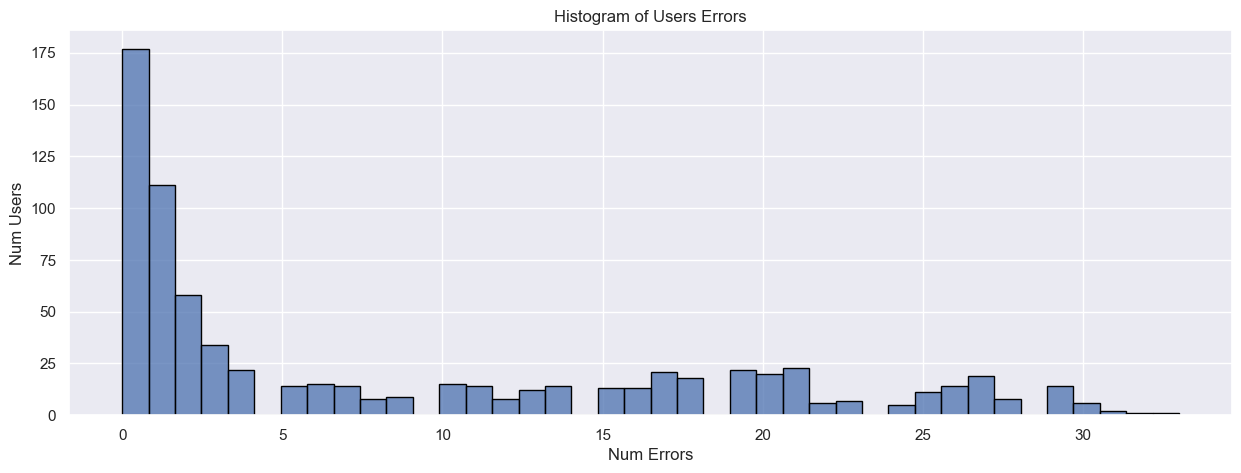

In [25]:
# calculate participants' errors
users_label_error = (labels != label_test).sum(axis=1)
users_pred_error = pred_test.apply(lambda x: (abs(x - preds.loc[x.name]) > 5).sum(), axis=1)
users_error = users_label_error + users_pred_error

# plot histogram of participants' error
p = sns.histplot(users_error, bins=40, edgecolor='black')
p.set(title='Histogram of Users Errors', xlabel='Num Errors', ylabel='Num Users')
plt.show()

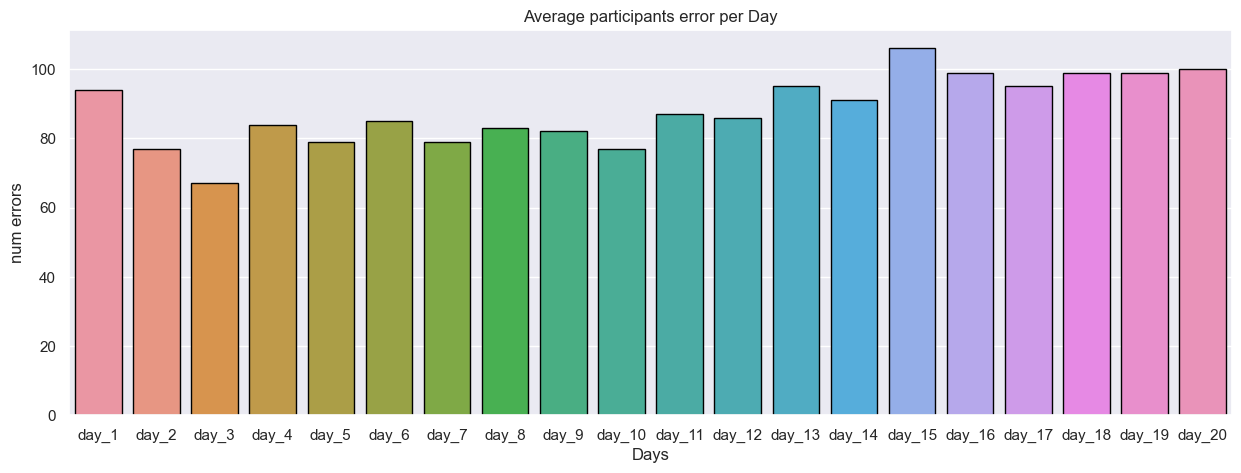

In [26]:
# calculate participants' errors per day
users_label_error_per_day = (labels != label_test).sum(axis=0)
users_pred_error_per_day = pred_test.apply(lambda x: (abs(x - preds.loc[x.name]) > 5), axis=1).sum(axis=0)
users_error_per_day = users_label_error_per_day

# plot participants' error per day
p = sns.barplot(x=users_error_per_day.index, y=users_error_per_day.values, edgecolor='black')
p.set(title='Average participants error per Day', ylabel='num errors', xlabel='Days')
plt.show()

### Analysis of good participants

In [27]:
allowed_errors = 5
days = 20

good_users_idx = users_error[users_error < allowed_errors].index
print(f'Number of users with less than {allowed_errors} errors: {len(good_users_idx)}')

Number of users with less than 5 errors: 402


Get every model indexes

In [28]:
# get good users
users_good = users.loc[good_users_idx]
model_indexes_good = {}

# get indexes of every model name
for model in models_names:
    model_indexes_good[model] = users_good.index[users_good['model_name'] == model].tolist()

Average user trust in the system

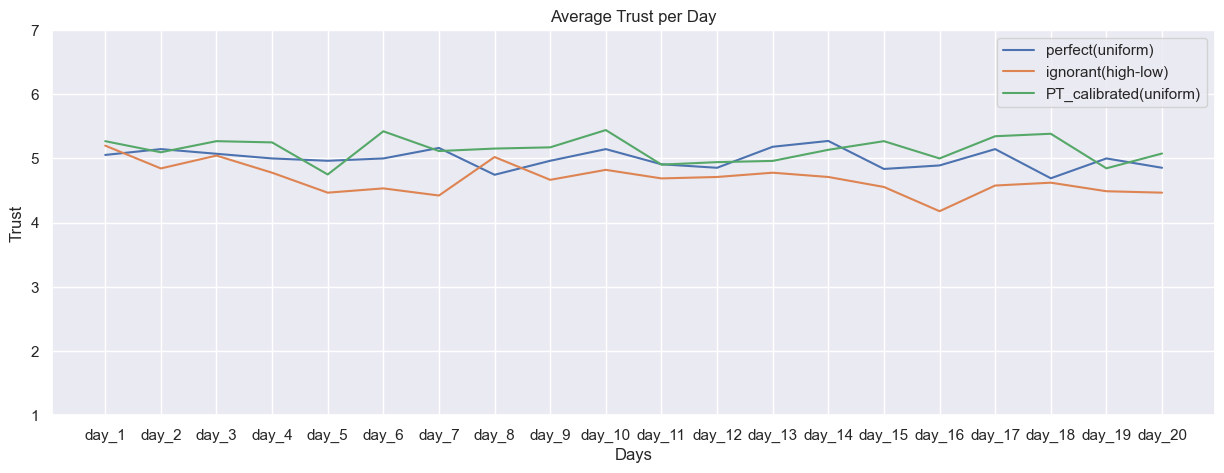

In [29]:
# calculate and plot average trust per day for each model
for model in models_names:
    last_rate_model = last_rate.loc[model_indexes_good[model]]
    last_rate_model_mean = last_rate_model.mean()
    p = sns.lineplot(x=last_rate.columns[:days], y=last_rate_model_mean[:days], 
                     dashes=False, markers=True, label=model)
    
p.set(ylim=(1, 7), title='Average Trust per Day', ylabel='Trust', xlabel='Days')
plt.show()

User actions according to system predictions

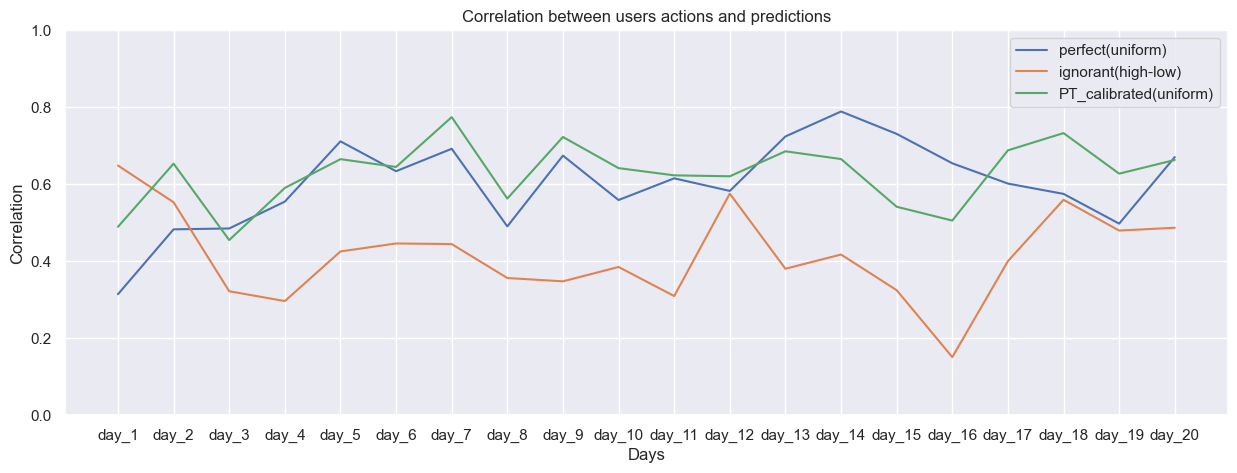

In [30]:
# calculate and plot correlation between model prediction and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes_good[model]]
    first_rate_model = first_rate.loc[model_indexes_good[model]]
    cors = preds_model.corrwith(first_rate_model, method='pearson')
    p = sns.lineplot(x=cors.index[:days], y=cors[:days], dashes=False, markers=True, label=model)

p.set(ylim=(0,1), title='Correlation between users actions and predictions', ylabel='Correlation', xlabel='Days')
plt.show()

### Check statistical significance on correlations

In [31]:
cors = pd.DataFrame(columns=models_names)

# create dataframe of correlations between model predictions and first_rate for each model
for model in models_names:
    preds_model = preds.loc[model_indexes[model]]
    first_rate_model = first_rate.loc[model_indexes[model]]
    cors[model] = preds_model.corrwith(first_rate_model, method='pearson')

# select days to analyze
start_day = 1
end_day = 20
cors = cors.iloc[start_day:end_day]
# print(cors)

# save cors to csv file
# cors.to_excel('output.xlsx', index=False)

In [32]:
# check statistical significance between models with t-test
for i in range(len(models_names)):
    for j in range(i+1, len(models_names)):
        model1 = models_names[i]
        model2 = models_names[j]
        t_statistic, p_value = stats.ttest_1samp(cors[model1] - cors[model2], 0)
        print(f'{model1} vs {model2}: t_statistic={t_statistic}, p_value={p_value}')

perfect(uniform) vs ignorant(high-low): t_statistic=6.20228694989723, p_value=7.467167625391876e-06
perfect(uniform) vs PT_calibrated(uniform): t_statistic=-2.896329197900046, p_value=0.0096213616815756
ignorant(high-low) vs PT_calibrated(uniform): t_statistic=-9.841968804841162, p_value=1.1405550223922621e-08
